# Qwen3 Model Architecture: Layer-by-Layer Implementation Guide

A focused guide for implementing each component of the Qwen3 model architecture.

## Architecture Overview

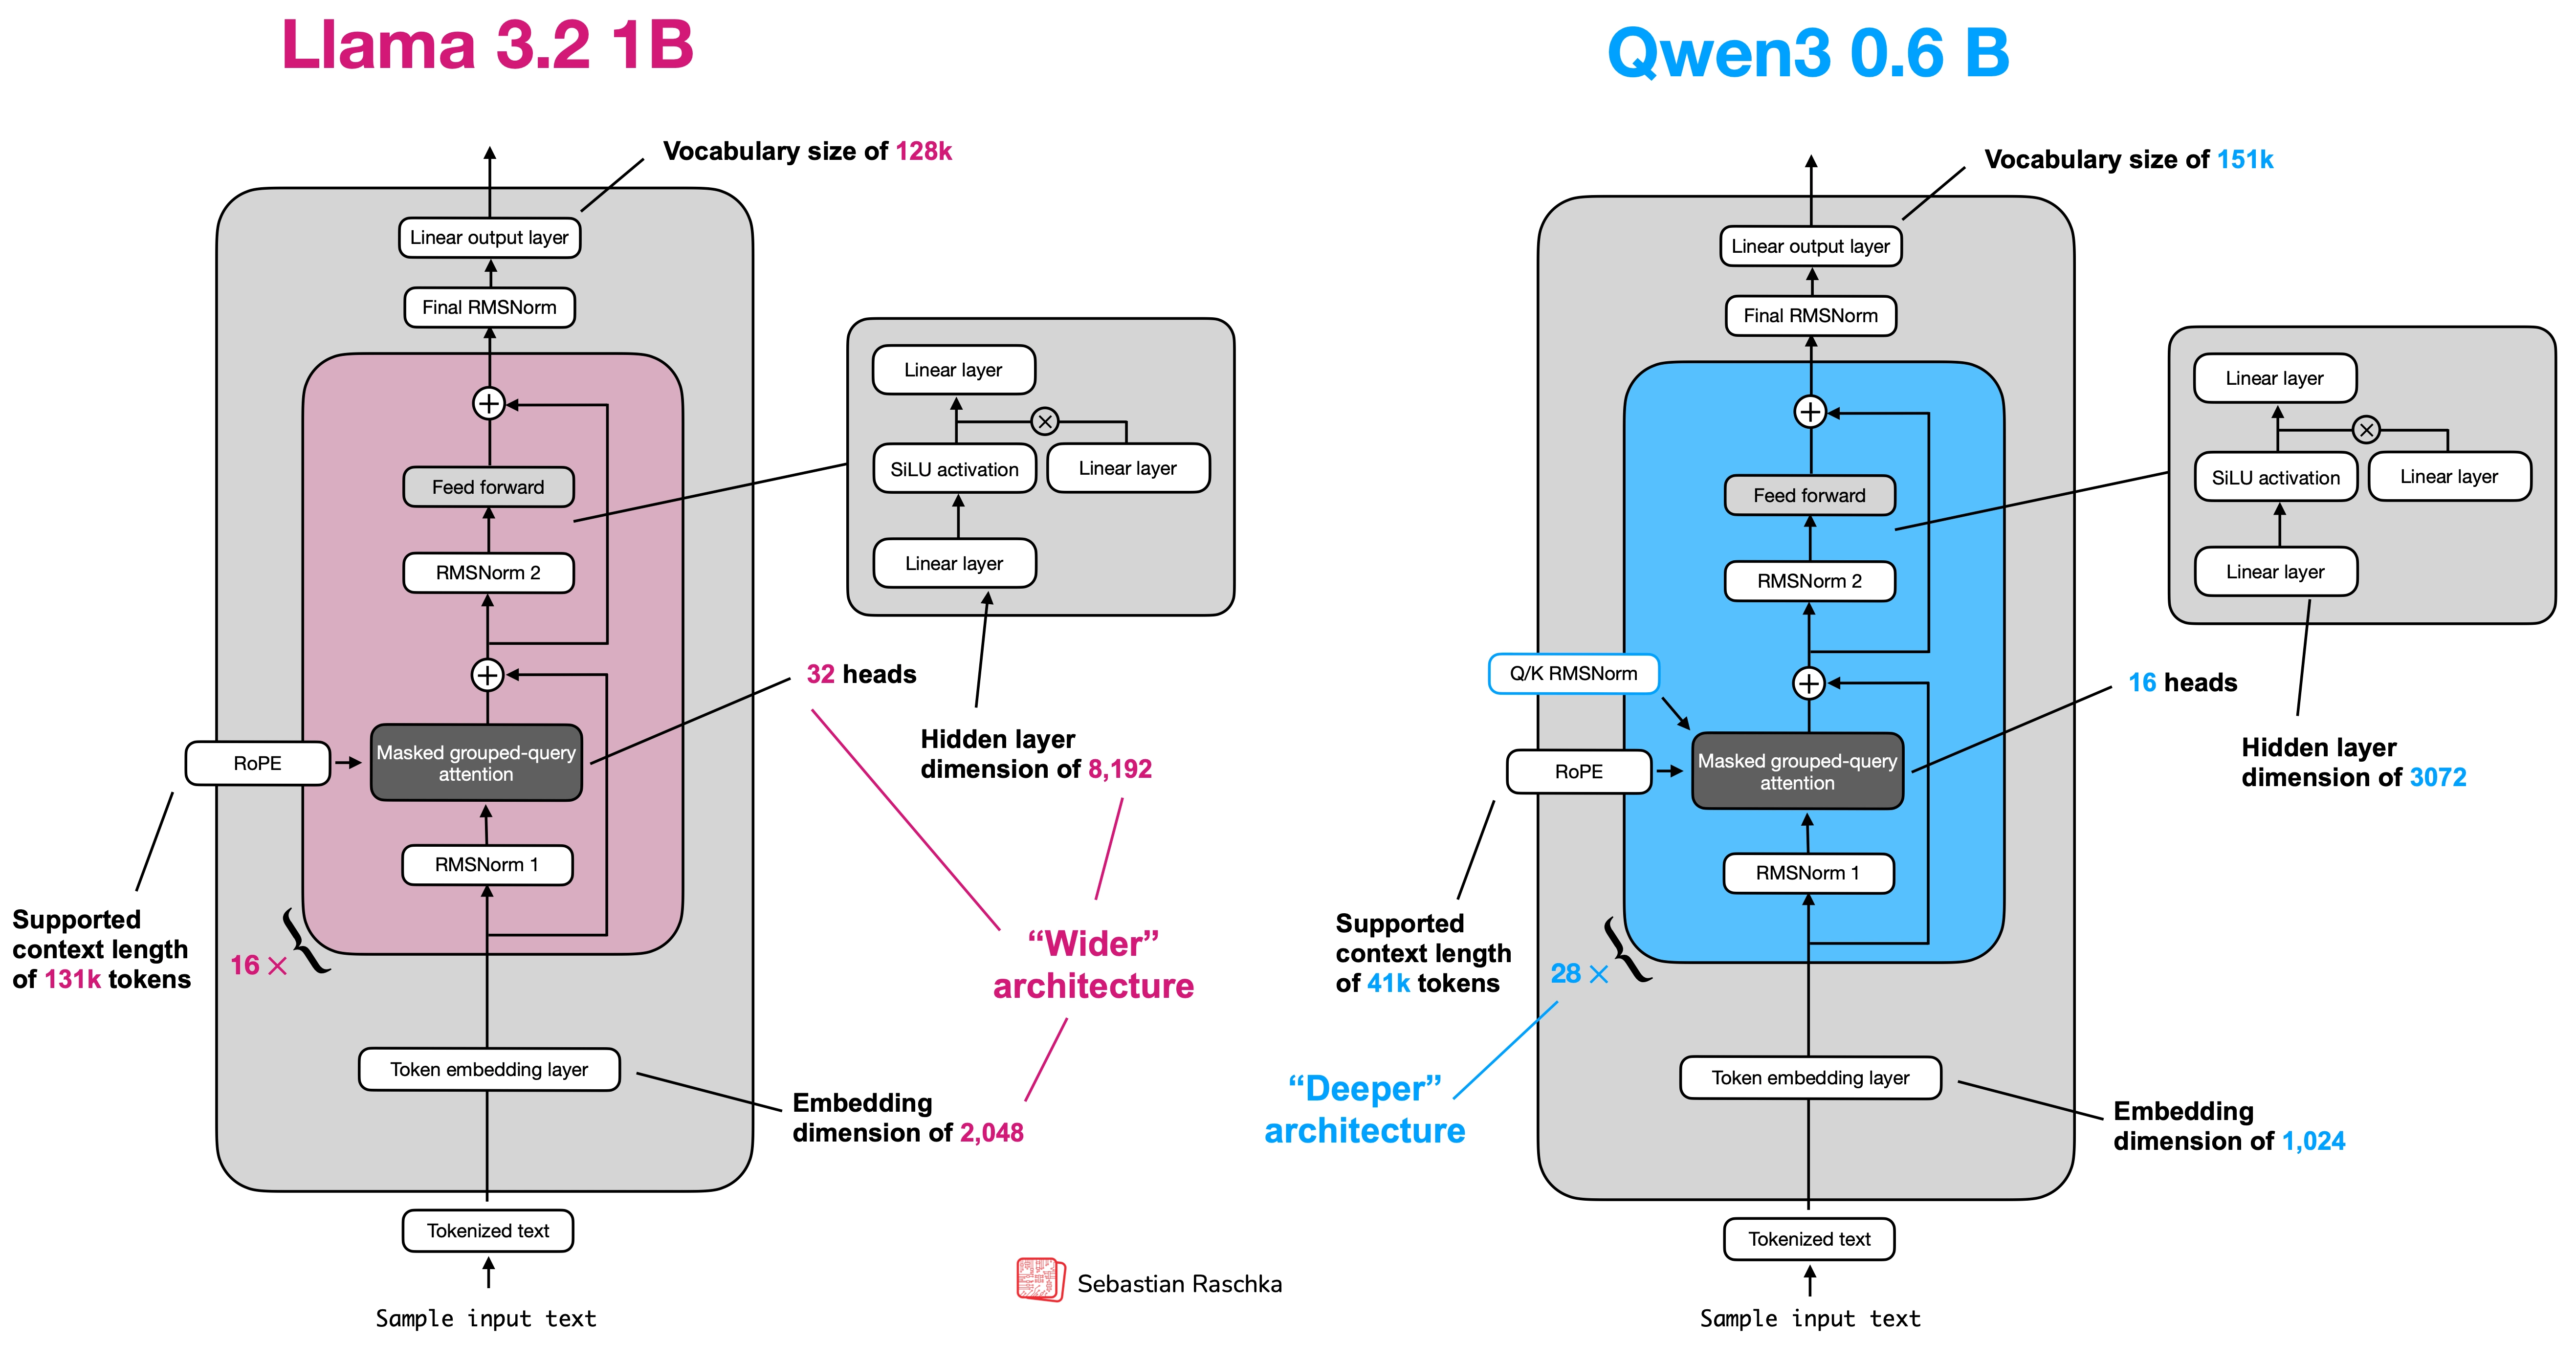

Qwen3's key architectural innovations:
- **QK-Norm**: Added to attention layers for training stability
- **Enhanced RoPE**: Base frequency 1M (vs 10K), supports 32K context
- **MoE**: 128 experts, 8 active, no shared experts
- **Thinking Mode**: Unified model with thinking/non-thinking capabilities

# Qwen3 Model Architecture: Layer-by-Layer Implementation Guide

A focused guide for implementing each component of the Qwen3 model architecture.

## Architecture Overview

Qwen3's key architectural innovations:
- **QK-Norm**: Added to attention layers for training stability
- **Enhanced RoPE**: Base frequency 1M (vs 10K), supports 32K context
- **MoE**: 128 experts, 8 active, no shared experts
- **Thinking Mode**: Unified model with thinking/non-thinking capabilities

## Loading Qwen3 from Config

```python
import torch
import torch.nn as nn
from dataclasses import dataclass
from typing import Optional
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

# Load official Qwen3 model and config
model_name = "Qwen/Qwen3-8B"
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Inspect the config to understand the architecture
print("Qwen3 Config:")
print(f"Hidden size: {config.hidden_size}")
print(f"Num layers: {config.num_hidden_layers}")
print(f"Num heads: {config.num_attention_heads}")
print(f"Vocab size: {config.vocab_size}")
print(f"Max position: {config.max_position_embeddings}")
print(f"RoPE base: {getattr(config, 'rope_base', 'Not found')}")
print(f"Uses QK-Norm: {getattr(config, 'use_qk_norm', 'Not found')}")

# Look at model structure
print("\nModel Structure:")
for name, module in model.named_modules():
    if len(list(module.children())) == 0:  # Leaf modules only
        print(f"{name}: {type(module).__name__}")
```

## Custom Config Class

```python
@dataclass
class Qwen3Config:
    # Model dimensions
    vocab_size: int = 151936
    hidden_size: int = 4096
    num_hidden_layers: int = 32
    num_attention_heads: int = 32
    num_key_value_heads: int = 32
    max_position_embeddings: int = 32768
    
    # RoPE
    rope_base: float = 1000000  # 1M base frequency
    
    # MoE (for MoE variants)
    num_experts: int = 128
    num_experts_per_tok: int = 8
    moe_intermediate_size: int = 1408
    
    # QK-Norm
    use_qk_norm: bool = True
    qk_norm_eps: float = 1e-6
    
    # Standard
    intermediate_size: int = 11008
    rms_norm_eps: float = 1e-6
    
    @classmethod
    def from_pretrained_config(cls, hf_config):
        """Create Qwen3Config from HuggingFace config"""
        return cls(
            vocab_size=hf_config.vocab_size,
            hidden_size=hf_config.hidden_size,
            num_hidden_layers=hf_config.num_hidden_layers,
            num_attention_heads=hf_config.num_attention_heads,
            num_key_value_heads=getattr(hf_config, 'num_key_value_heads', hf_config.num_attention_heads),
            max_position_embeddings=hf_config.max_position_embeddings,
            rope_base=getattr(hf_config, 'rope_base', 1000000),
            intermediate_size=hf_config.intermediate_size,
            use_qk_norm=getattr(hf_config, 'use_qk_norm', True),
        )

# Create config from loaded model
qwen3_config = Qwen3Config.from_pretrained_config(config)
print(f"\nCustom config created: {qwen3_config}")
```

## Layer Implementation Order

### 1. RMSNorm
Base normalization used throughout the model.

### 2. QKNorm  
Query-Key normalization for attention stability.

### 3. RotaryEmbedding
Enhanced RoPE with 1M base frequency for long context.

### 4. Attention
Multi-head attention with QK-Norm and RoPE.

### 5. MLP
Standard feed-forward network (for dense models).

### 6. MoE
Mixture of Experts layer (for MoE variants).

### 7. DecoderLayer
Complete transformer block combining attention + MLP/MoE.

### 8. Model
Full model with embeddings, layers, and output head.

## Key Implementation Notes

**QK-Norm Integration**
- Apply to queries and keys before RoPE
- Separate normalization for Q and K
- Only in attention layers

**RoPE Scaling**
- Base frequency: 1,000,000 (not 10,000)
- Supports native 32K context
- Compatible with YARN for extension

**MoE Specifics**
- 128 total experts
- 8 experts active per token
- No shared experts (unlike Qwen2.5)
- Global load balancing loss

**Thinking Mode**
- Special tokens: `<|thinking|>` and `<|/thinking|>`
- Unified architecture (no separate models)
- Controlled via attention masking

Start with RMSNorm and work through each layer systematically.

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class RMSNorm(nn.Module):
    def __init__(self, normalized_shape: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.gain = nn.Parameter(torch.ones(normalized_shape))

    def forward(self, x: torch.Tensor):
        rms = torch.sqrt(torch.mean(x.pow(2), dim=-1, keepdim=True) + self.eps)
        return (x / rms) * self.gain

In [3]:
class QKNorm(nn.Module):
    def __init__(self, head_dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.q_norm = RMSNorm(head_dim, eps)
        self.k_norm = RMSNorm(head_dim, eps)

    def forward(self, q: torch.Tensor, k: torch.Tensor):
        # q, k shape: [batch, num_heads, seq_len, head_dim]
        q_normalized = self.q_norm(q)
        k_normalized = self.k_norm(k)
        return q_normalized, k_normalized

In [4]:
class RotaryEmbedding(nn.Module):
    def __init__(self, head_dim: int, max_seq_len: int = 32768, base: float = 1000000):
        super().__init__()
        self.head_dim = head_dim
        self.max_seq_len = max_seq_len
        self.base = base

        # Precompute and cache frequencies
        inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2).float() / head_dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        # Precompute cos/sin for max sequence length
        self._update_cos_sin_cache(max_seq_len)

    def _update_cos_sin_cache(self, seq_len: int):
        """Update cached cos/sin values for given sequence length"""
        if seq_len > self.max_seq_len:
            self.max_seq_len = seq_len

        # Create position indices
        t = torch.arange(seq_len, device=self.inv_freq.device).float()

        # Compute frequencies: outer product of positions and inv_freq
        freqs = torch.outer(t, self.inv_freq)  # [seq_len, head_dim//2]

        # Duplicate frequencies for cos/sin pairs: [a, b] -> [a, a, b, b]
        freqs = torch.cat([freqs, freqs], dim=-1)  # [seq_len, head_dim]

        # Cache cos and sin
        self.register_buffer("cos_cache", freqs.cos(), persistent=False)
        self.register_buffer("sin_cache", freqs.sin(), persistent=False)

    def forward(self, x: torch.Tensor, seq_len: int = None):
        """Get cos/sin values for sequence length"""
        if seq_len is None:
            seq_len = x.shape[-2]

        if seq_len > self.max_seq_len:
            self._update_cos_sin_cache(seq_len)

        return self.cos_cache[:seq_len], self.sin_cache[:seq_len]


def rotate_half(x):
    """Rotate half the hidden dims: [a, b, c, d] -> [-c, -d, a, b]"""
    x1 = x[..., : x.shape[-1] // 2]  # First half
    x2 = x[..., x.shape[-1] // 2 :]  # Second half
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None):
    """Apply rotary position embedding to query and key tensors"""
    if position_ids is not None:
        cos = cos[position_ids].unsqueeze(1)  # [batch, 1, seq_len, head_dim]
        sin = sin[position_ids].unsqueeze(1)
    else:
        cos = cos.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, head_dim]
        sin = sin.unsqueeze(0).unsqueeze(0)

    # Apply rotation: x * cos + rotate_half(x) * sin
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [5]:
class Qwen3Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads

        # Linear projections - note the bias settings
        self.q_proj = nn.Linear(
            self.hidden_size, self.num_heads * self.head_dim, bias=True
        )
        self.k_proj = nn.Linear(
            self.hidden_size, self.num_key_value_heads * self.head_dim, bias=True
        )
        self.v_proj = nn.Linear(
            self.hidden_size, self.num_key_value_heads * self.head_dim, bias=True
        )
        self.o_proj = nn.Linear(
            self.num_heads * self.head_dim, self.hidden_size, bias=False
        )

        # QKNorm for training stability
        if config.use_qk_norm:
            self.qk_norm = QKNorm(self.head_dim, config.qk_norm_eps)
        else:
            self.qk_norm = None

        # RoPE
        self.rotary_emb = RotaryEmbedding(
            self.head_dim,
            max_seq_len=config.max_position_embeddings,
            base=config.rope_base,
        )

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        position_ids=None,
        past_key_value=None,
        use_cache=False,
    ):
        batch_size, seq_len, _ = hidden_states.size()

        # Project to Q, K, V
        query_states = self.q_proj(hidden_states)
        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)

        # Reshape for multi-head attention
        query_states = query_states.view(
            batch_size, seq_len, self.num_heads, self.head_dim
        ).transpose(1, 2)
        key_states = key_states.view(
            batch_size, seq_len, self.num_key_value_heads, self.head_dim
        ).transpose(1, 2)
        value_states = value_states.view(
            batch_size, seq_len, self.num_key_value_heads, self.head_dim
        ).transpose(1, 2)

        # Apply QKNorm before RoPE
        if self.qk_norm is not None:
            query_states, key_states = self.qk_norm(query_states, key_states)

        # Apply RoPE
        cos, sin = self.rotary_emb(value_states, seq_len)
        query_states, key_states = apply_rotary_pos_emb(
            query_states, key_states, cos, sin, position_ids
        )

        # Handle past key/value for generation
        if past_key_value is not None:
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)

        past_key_value = (key_states, value_states) if use_cache else None

        # Repeat k/v heads for GQA
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        # Compute attention scores - FIXED: use head_dim for scaling
        attn_weights = torch.matmul(
            query_states, key_states.transpose(2, 3)
        ) / math.sqrt(self.head_dim)

        # Apply attention mask
        if attention_mask is not None:
            attn_weights = attn_weights + attention_mask

        # Apply softmax
        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).to(
            query_states.dtype
        )

        # Compute output
        attn_output = torch.matmul(attn_weights, value_states)

        # Reshape and project
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(batch_size, seq_len, self.hidden_size)
        attn_output = self.o_proj(attn_output)

        return attn_output, attn_weights, past_key_value


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """Repeat key/value tensors n_rep times for GQA"""
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(
        batch, num_key_value_heads, n_rep, slen, head_dim
    )
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

In [6]:
class Qwen3MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size

        # SwiGLU requires 3 projections: gate, up, down
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)

        # SiLU activation (same as Swish)
        self.act_fn = nn.SiLU()

    def forward(self, x):
        # SwiGLU: swish(gate(x)) * up(x)
        gate_output = self.act_fn(self.gate_proj(x))
        up_output = self.up_proj(x)
        intermediate = gate_output * up_output
        return self.down_proj(intermediate)


class Qwen3MoE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_experts = config.num_experts  # 128
        self.top_k = config.num_experts_per_tok  # 8
        self.intermediate_size = config.moe_intermediate_size  # 1408

        # Router to select experts
        self.gate = nn.Linear(self.hidden_size, self.num_experts, bias=False)

        # 128 expert networks (each is a SwiGLU FFN)
        self.experts = nn.ModuleList(
            [
                Qwen3Expert(self.hidden_size, self.intermediate_size)
                for _ in range(self.num_experts)
            ]
        )

        # Load balancing loss coefficient
        self.router_aux_loss_coef = 0.01

    def forward(self, hidden_states):
        batch_size, seq_len, hidden_dim = hidden_states.shape
        hidden_states = hidden_states.view(-1, hidden_dim)  # Flatten for routing

        # Route tokens to experts
        router_logits = self.gate(hidden_states)  # [batch*seq, num_experts]
        routing_weights, selected_experts = torch.topk(
            router_logits, self.top_k, dim=-1
        )
        routing_weights = F.softmax(routing_weights, dim=-1)

        # Initialize output
        final_hidden_states = torch.zeros_like(hidden_states)

        # Process each expert
        for expert_idx in range(self.num_experts):
            # Find tokens assigned to this expert
            expert_mask = selected_experts == expert_idx
            expert_tokens = expert_mask.any(dim=-1)

            if not expert_tokens.any():
                continue

            # Get token indices for this expert
            token_indices = torch.where(expert_tokens)[0]
            current_tokens = hidden_states[token_indices]

            # Process through expert
            expert_output = self.experts[expert_idx](current_tokens)

            # Weight by routing weights and add to final output
            for i, token_idx in enumerate(token_indices):
                expert_positions = torch.where(expert_mask[token_idx])[0]
                for pos in expert_positions:
                    weight = routing_weights[token_idx, pos]
                    final_hidden_states[token_idx] += weight * expert_output[i]

        # Compute load balancing loss
        aux_loss = self._compute_routing_loss(router_logits, selected_experts)

        # Reshape back
        final_hidden_states = final_hidden_states.view(batch_size, seq_len, hidden_dim)
        return final_hidden_states, aux_loss

    def _compute_routing_loss(self, router_logits, selected_experts):
        """Load balancing loss to encourage uniform expert usage"""
        num_tokens = router_logits.shape[0]

        # Expert usage frequency
        expert_counts = torch.bincount(
            selected_experts.view(-1), minlength=self.num_experts
        )
        expert_freq = expert_counts.float() / (num_tokens * self.top_k)

        # Router probabilities
        router_probs = F.softmax(router_logits, dim=-1).mean(dim=0)

        # Load balancing loss
        aux_loss = self.num_experts * torch.sum(expert_freq * router_probs)
        return self.router_aux_loss_coef * aux_loss


class Qwen3Expert(nn.Module):
    """Individual expert - same as regular FFN"""

    def __init__(self, hidden_size, intermediate_size):
        super().__init__()
        self.gate_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.up_proj = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.down_proj = nn.Linear(intermediate_size, hidden_size, bias=False)
        self.act_fn = nn.SiLU()

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

In [7]:
class Qwen3DecoderLayer(nn.Module):
    def __init__(self, config, layer_idx=None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.hidden_size = config.hidden_size

        # Self-attention
        self.self_attn = Qwen3Attention(config)

        # FFN or MoE (depending on model variant)
        if hasattr(config, "num_experts") and config.num_experts > 0:
            self.mlp = Qwen3MoE(config)
        else:
            self.mlp = Qwen3MLP(config)

        # Layer norms (RMSNorm in Qwen3)
        self.input_layernorm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = RMSNorm(
            config.hidden_size, eps=config.rms_norm_eps
        )

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        position_ids=None,
        past_key_value=None,
        use_cache=False,
        **kwargs,
    ):
        residual = hidden_states

        # Pre-norm for attention
        hidden_states = self.input_layernorm(hidden_states)

        # Self-attention
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            use_cache=use_cache,
        )

        # Residual connection
        hidden_states = residual + hidden_states

        # Pre-norm for FFN/MoE
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)

        # FFN/MoE
        if isinstance(self.mlp, Qwen3MoE):
            hidden_states, aux_loss = self.mlp(hidden_states)
        else:
            hidden_states = self.mlp(hidden_states)
            aux_loss = None

        # Residual connection
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)
        if use_cache:
            outputs += (present_key_value,)
        if aux_loss is not None:
            outputs += (aux_loss,)

        return outputs

In [8]:
class Qwen3Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.vocab_size = config.vocab_size
        self.hidden_size = config.hidden_size

        # Token embeddings (no positional - RoPE handles positions)
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)

        # Decoder layers
        self.layers = nn.ModuleList(
            [
                Qwen3DecoderLayer(config, layer_idx=i)
                for i in range(config.num_hidden_layers)
            ]
        )

        # Final layer norm
        self.norm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        past_key_values=None,
        use_cache=None,
        **kwargs
    ):
        batch_size, seq_length = input_ids.shape

        # Token embeddings
        hidden_states = self.embed_tokens(input_ids)

        # Create position IDs if not provided
        if position_ids is None:
            device = input_ids.device
            position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)

        # Create causal mask
        if attention_mask is None:
            attention_mask = torch.ones(
                (batch_size, seq_length), dtype=torch.bool, device=hidden_states.device
            )

        # Convert to 4D causal mask
        attention_mask = self._prepare_decoder_attention_mask(
            attention_mask, (batch_size, seq_length), hidden_states
        )

        # Initialize cache
        if use_cache and past_key_values is None:
            past_key_values = tuple([None] * len(self.layers))

        # Forward through layers
        presents = () if use_cache else None
        all_router_aux_losses = []

        for i, layer in enumerate(self.layers):
            past_key_value = past_key_values[i] if past_key_values is not None else None

            layer_outputs = layer(
                hidden_states,
                attention_mask=attention_mask,
                position_ids=position_ids,
                past_key_value=past_key_value,
                use_cache=use_cache,
            )

            hidden_states = layer_outputs[0]

            if use_cache:
                presents = presents + (layer_outputs[1],)

            # Collect MoE auxiliary losses
            if len(layer_outputs) > 2:  # Has aux loss
                all_router_aux_losses.append(layer_outputs[2])

        # Final layer norm
        hidden_states = self.norm(hidden_states)

        return {
            "last_hidden_state": hidden_states,
            "past_key_values": presents,
            "router_aux_losses": all_router_aux_losses,
        }

    def _prepare_decoder_attention_mask(
        self, attention_mask, input_shape, hidden_states
    ):
        """Create 4D causal attention mask"""
        batch_size, seq_length = input_shape

        # Create causal mask
        causal_mask = torch.tril(torch.ones(seq_length, seq_length, dtype=torch.bool))
        causal_mask = causal_mask.to(hidden_states.device)

        # Expand dimensions: [seq_len, seq_len] -> [batch, 1, seq_len, seq_len]
        causal_mask = causal_mask[None, None, :, :].expand(
            batch_size, 1, seq_length, seq_length
        )

        # Apply padding mask if provided
        if attention_mask is not None:
            # attention_mask: [batch, seq_len] -> [batch, 1, 1, seq_len]
            attention_mask = attention_mask[:, None, None, :]
            # Combine with causal mask
            causal_mask = causal_mask & attention_mask

        # Convert to additive mask (0 for attend, -inf for mask)
        causal_mask = torch.where(causal_mask, 0.0, float("-inf"))

        return causal_mask


class Qwen3ForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Base model
        self.model = Qwen3Model(config)

        # Language modeling head
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Tie weights if specified
        if config.tie_word_embeddings:
            self.lm_head.weight = self.model.embed_tokens.weight

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        past_key_values=None,
        labels=None,
        use_cache=None,
        **kwargs
    ):
        # Forward through model
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            use_cache=use_cache,
        )

        hidden_states = outputs["last_hidden_state"]

        # Language modeling logits
        logits = self.lm_head(hidden_states)

        loss = None
        if labels is not None:
            # Shift labels for causal LM
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            # Calculate cross entropy loss
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)
            )

            # Add MoE auxiliary loss if present
            if outputs["router_aux_losses"]:
                aux_loss = sum(outputs["router_aux_losses"]) / len(
                    outputs["router_aux_losses"]
                )
                loss = loss + aux_loss

        return {
            "loss": loss,
            "logits": logits,
            "past_key_values": outputs["past_key_values"],
        }

In [ ]:
from typing import Optional
from dataclasses import dataclass
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

model_name = "Qwen/Qwen3-8B"
config = AutoConfig.from_pretrained(model_name)


@dataclass
class Qwen3Config:
    # Model dimensions
    vocab_size: int = 151936
    hidden_size: int = 4096
    num_hidden_layers: int = 32
    num_attention_heads: int = 32
    num_key_value_heads: int = 32
    max_position_embeddings: int = 32768

    # RoPE
    rope_base: float = 1000000  # 1M base frequency

    # MoE (for MoE variants)
    num_experts: int = 0  # 0 for dense, >0 for MoE
    num_experts_per_tok: int = 8
    moe_intermediate_size: int = 1408

    # QK-Norm
    use_qk_norm: bool = True
    qk_norm_eps: float = 1e-6

    # Standard
    intermediate_size: int = 11008
    rms_norm_eps: float = 1e-6

    # Model settings
    tie_word_embeddings: bool = False
    use_cache: bool = True

    @classmethod
    def from_pretrained_config(cls, hf_config):
        """Create Qwen3Config from HuggingFace config"""
        return cls(
            vocab_size=hf_config.vocab_size,
            hidden_size=hf_config.hidden_size,
            num_hidden_layers=hf_config.num_hidden_layers,
            num_attention_heads=hf_config.num_attention_heads,
            num_key_value_heads=getattr(
                hf_config, "num_key_value_heads", hf_config.num_attention_heads
            ),
            max_position_embeddings=hf_config.max_position_embeddings,
            rope_base=getattr(hf_config, "rope_base", 1000000),
            intermediate_size=hf_config.intermediate_size,
            use_qk_norm=getattr(hf_config, "use_qk_norm", True),
        )


# Create config from loaded model
qwen3_config = Qwen3Config.from_pretrained_config(config)
print(f"\nCustom config created: {qwen3_config}")


# Create config from loaded model
qwen3_config = Qwen3Config.from_pretrained_config(config)
print(f"\nCustom config created: {qwen3_config}")


# Quick smoke test
def quick_test():
    config = Qwen3Config(vocab_size=1000, hidden_size=256, num_hidden_layers=2)
    model = Qwen3ForCausalLM(config)

    input_ids = torch.randint(0, 1000, (1, 10))
    outputs = model(input_ids)

    print(f"✅ Model runs! Output shape: {outputs['logits'].shape}")


quick_test()


Custom config created: Qwen3Config(vocab_size=151936, hidden_size=4096, num_hidden_layers=36, num_attention_heads=32, num_key_value_heads=8, max_position_embeddings=40960, rope_base=1000000, num_experts=0, num_experts_per_tok=8, moe_intermediate_size=1408, use_qk_norm=True, qk_norm_eps=1e-06, intermediate_size=12288, rms_norm_eps=1e-06, tie_word_embeddings=False, use_cache=True)

Custom config created: Qwen3Config(vocab_size=151936, hidden_size=4096, num_hidden_layers=36, num_attention_heads=32, num_key_value_heads=8, max_position_embeddings=40960, rope_base=1000000, num_experts=0, num_experts_per_tok=8, moe_intermediate_size=1408, use_qk_norm=True, qk_norm_eps=1e-06, intermediate_size=12288, rms_norm_eps=1e-06, tie_word_embeddings=False, use_cache=True)
✅ Model runs! Output shape: torch.Size([1, 10, 1000])
